In [280]:
import pandas as pd

Наши новости

In [281]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [282]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 1. Получаем векторные представления новостей

In [283]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [284]:
#предобработка текстов
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel
import gensim
import pymorphy2  # pip install pymorphy2
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [285]:
#nltk.download('stopwords')
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

morph = pymorphy2.MorphAnalyzer()

151


In [286]:
with open('stopwords.txt', encoding="utf-8") as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

778

In [287]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [288]:
print(news.head(5))
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)


   doc_id                                              title
0       6  Заместитель председателяnправительства РФnСерг...
1    4896  Матч 1/16 финала Кубка России по футболу был п...
2    4897  Форвард «Авангарда» Томаш Заборский прокоммент...
3    4898  Главный тренер «Кубани» Юрий Красножан прокомм...
4    4899  Решением попечительского совета владивостокско...
UsageError: Line magic function `%%time` not found.


In [289]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

news.head(5)

Wall time: 4min 55s


,doc_id,title
0,6,"[заместитель, председатель, правительство, рф,..."
1,4896,"[матч, 1/16, финал, кубок, россия, футбол, при..."
2,4897,"[форвард, авангард, томаш, заборский, прокомме..."
3,4898,"[главный, тренер, кубань, юрий, красножанин, п..."
4,4899,"[решение, попечительский, совет, владивостокск..."


А теперь в 3 строчки обучим нашу модель

In [290]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]
# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [291]:
common_dictionary[1]
#common_corpus

'алексей'

Все просто - это словарь наших слов

Запускаем обучение

In [292]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 1min 5s


In [293]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [294]:
lda.print_topics()

[(11,
  '0.027*"доллар" + 0.021*"производитель" + 0.020*"влиять" + 0.016*"египет" + 0.015*"турецкий" + 0.013*"рекомендовать" + 0.012*"одежда" + 0.010*"еда" + 0.009*"греция" + 0.008*"рост"'),
 (24,
  '0.083*"взрыв" + 0.077*"поверхность" + 0.029*"маршрут" + 0.016*"парка" + 0.016*"диск" + 0.016*"святой" + 0.015*"петербург" + 0.015*"армения" + 0.014*"обвинить" + 0.012*"экскурсия"'),
 (22,
  '0.043*"сибирский" + 0.026*"колебаться" + 0.024*"близость" + 0.024*"русь" + 0.023*"ирландия" + 0.023*"калинин" + 0.017*"винтовка" + 0.013*"ткачёв" + 0.012*"слегка" + 0.010*"рекордсмен"'),
 (8,
  '0.039*"исследование" + 0.024*"газ" + 0.015*"население" + 0.010*"пациент" + 0.010*"территория" + 0.008*"британский" + 0.007*"участок" + 0.007*"помощь" + 0.007*"остров" + 0.006*"писать"'),
 (16,
  '0.015*"ребёнок" + 0.013*"банк" + 0.012*"россия" + 0.011*"гражданин" + 0.009*"правительство" + 0.009*"власть" + 0.008*"глава" + 0.007*"рф" + 0.007*"область" + 0.007*"санкция"'),
 (23,
  '0.193*"фонд" + 0.038*"сенатор" +

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [295]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(0, 0.04390315),
 (2, 0.20388804),
 (5, 0.03202971),
 (11, 0.122907795),
 (13, 0.13482176),
 (15, 0.35018522),
 (18, 0.09269801)]

In [324]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: район сотрудник произойти пострадать убийство действие москва
topic_1: проект земля система цена эксперт экономика технология
topic_2: ракета статья украинский киев новый часть украина
topic_3: миссия двигатель больной отряд студия сопровождать писать
topic_4: погибнуть эксперимент армия восток источник полицейский расстояние
topic_5: рейтинг северный место теория смерть испытание вуз
topic_6: военный журнал станция сша россия российский наука
topic_7: доллар мальчик обращение постановление вскоре бизнесмен обнаружить
topic_8: исследование газ население пациент территория британский участок
topic_9: путин песок пресс-секретарь владимир отреагировать россия умирать
topic_10: свидетель израиль товар общество норвегия медведь командировка
topic_11: доллар производитель влиять египет турецкий рекомендовать одежда
topic_12: украина российский решение сторона россия источник вопрос
topic_13: всё жизнь n— день очень большой первый
topic_14: тело врач com лечение живой белоруссия nnn


Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [297]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, common_corpus, common_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
21    -0.216295  0.013022       1        1  14.215197
16    -0.187778 -0.090812       2        1  11.215804
12    -0.191870 -0.088830       3        1  10.634434
19    -0.175894  0.028182       4        1  10.176171
13    -0.182329  0.101580       5        1  10.060444
0     -0.139694 -0.084648       6        1   7.645646
1     -0.173052  0.042492       7        1   6.054518
6     -0.130678 -0.086514       8        1   4.912175
8     -0.157648  0.015173       9        1   4.830923
2     -0.153529  0.033434      10        1   4.539808
18    -0.096553  0.109681      11        1   2.390268
15     0.051008  0.156056      12        1   2.352063
4      0.011603 -0.118482      13        1   1.739263
17    -0.020114 -0.231321      14        1   1.735851
11    -0.030638  0.071290      15        1   1.499293
14     0.032998  0.050975      16        1   1.337621
5      0.020645  0.109774      17        1   1.218247
20     0.133509  0.082368      18        1   0.703799
9      0.155038 -0.056274      19        1   0.647230
24     0.175829  0.027834      20        1   0.627636
3      0.132352  0.018074      21        1   0.465654
23     0.227616 -0.048401      22        1   0.414338
7      0.215416 -0.015095      23        1   0.345080
10     0.342792 -0.026038      24        1   0.158027
22     0.357265 -0.013519      25        1   0.080510, topic_info=               Term          Freq         Total Category  logprob  loglift
436            фонд   7840.000000   7840.000000  Default  30.0000  30.0000
9725   исследование  16262.000000  16262.000000  Default  29.0000  29.0000
11944       военный  13059.000000  13059.000000  Default  28.0000  28.0000
5458          путин   7632.000000   7632.000000  Default  27.0000  27.0000
117          россия  51310.000000  51310.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
10243          русь    131.668975    269.686973  Topic25  -3.7446   6.4076
2349          рашид     23.973266     45.524398  Topic25  -5.4480   6.4832
5852       ирландия    130.345406    351.178663  Topic25  -3.7547   6.1334
13005        полина     10.278408     39.466617  Topic25  -6.2949   5.7791
2341      ворваться     11.453360    227.636811  Topic25  -6.1866   4.1351

[1671 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2065      1  0.094896       ...
2065      2  0.241569       ...
2065      3  0.062452       ...
2065      4  0.012188       ...
2065      5  0.185926       ...
...     ...       ...       ...
6971      7  0.757283  японский
6971     12  0.156288  японский
6971     13  0.078884  японский
6971     14  0.000986  японский
6971     16  0.003451  японский

[6944 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 17, 13, 20, 14, 1, 2, 7, 9, 3, 19, 16, 5, 18, 12, 15, 6, 21, 10, 25, 4, 24, 8, 11, 23])

In [424]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [425]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.068951,0.631113,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
1,4896,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.262279,0.216398,0.0,0.189974,0.0,0.0,0.000000,0.0,0.0,0.309224
2,4897,0.043656,0.0,0.203858,0.0,0.0,0.031892,0.0,0.0,0.0,...,0.350136,0.000000,0.0,0.093127,0.0,0.0,0.000000,0.0,0.0,0.000000
3,4898,0.087094,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.105347,0.000000,0.0,0.026874,0.0,0.0,0.132428,0.0,0.0,0.000000
4,4899,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.138062,0.834760,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [426]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [427]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [428]:
doc_dict[293622]

array([0.        , 0.        , 0.15589648, 0.        , 0.        ,
       0.        , 0.06143218, 0.        , 0.15436827, 0.04654723,
       0.        , 0.023049  , 0.        , 0.11864883, 0.        ,
       0.08256622, 0.24849117, 0.        , 0.04070448, 0.        ,
       0.        , 0.0580959 , 0.        , 0.        , 0.        ])

In [429]:
user_articles_list = users['articles'].iloc[33]
print(user_articles_list)

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector





[323329, 321961, 324743, 323186, 324632, 474690]


In [462]:
get_user_embedding(user_articles_list)

array([0.1105391 , 0.02194226, 0.04572142, 0.        , 0.        ,
       0.        , 0.07512093, 0.        , 0.04157868, 0.04769249,
       0.        , 0.00338957, 0.12598011, 0.06488236, 0.04889409,
       0.        , 0.08336488, 0.0272664 , 0.00619261, 0.13526645,
       0.        , 0.14809814, 0.        , 0.        , 0.        ])

Интересовался новостями с топиками topic_0, topic_12, topic_21 (что-то про политику и государство)

In [463]:
#users['articles'].iloc[33]

In [464]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [465]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.074488,0.096393,0.054243,0.000000,0.032014,0.000000,0.068654,0.000000,0.033902,...,0.110829,0.221188,0.015182,0.019089,0.075879,0.0,0.038162,0.0,0.000000,0.007751
1,u108690,0.111994,0.021278,0.039741,0.002343,0.007088,0.006187,0.023092,0.003296,0.043233,...,0.013848,0.101074,0.011957,0.012754,0.058793,0.0,0.149530,0.0,0.002937,0.000000
2,u108339,0.192181,0.032690,0.027179,0.001786,0.031666,0.010124,0.045474,0.007541,0.045334,...,0.000000,0.169350,0.016046,0.024586,0.107596,0.0,0.023008,0.0,0.010605,0.004146


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [466]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [467]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.074488,0.096393,0.054243,0.000000,0.032014,0.000000,0.068654,0.000000,0.033902,...,0.221188,0.015182,0.019089,0.075879,0.0,0.038162,0.0,0.000000,0.007751,0
1,u108690,0.111994,0.021278,0.039741,0.002343,0.007088,0.006187,0.023092,0.003296,0.043233,...,0.101074,0.011957,0.012754,0.058793,0.0,0.149530,0.0,0.002937,0.000000,1
2,u108339,0.192181,0.032690,0.027179,0.001786,0.031666,0.010124,0.045474,0.007541,0.045334,...,0.169350,0.016046,0.024586,0.107596,0.0,0.023008,0.0,0.010605,0.004146,1


In [468]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [469]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [470]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [471]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.27315419, 0.02603109, 0.34763595, 0.21102835, 0.04552626,
       0.12109406, 0.21767101, 0.00735559, 0.04623274, 0.34994051])

In [472]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools

### Рассчитаем Precision, Recall, F_score

In [473]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))


Best Threshold=0.264601, F-Score=0.691, Precision=0.629, Recall=0.767


In [474]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1644  111]
 [  58  187]]


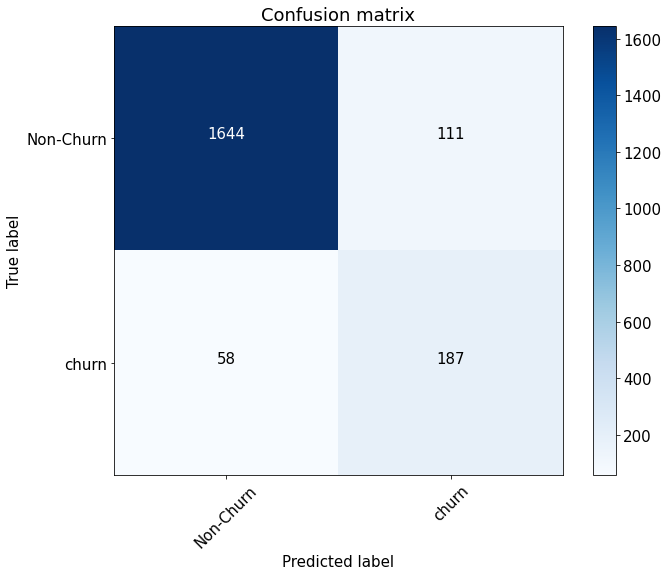

In [475]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [476]:
roc = roc_auc_score(y_test, preds)


df2 = pd.DataFrame(
        {
            "name": np.array(['mean']),
            "precision": np.array([precision[ix]]),
            "recall": np.array([recall[ix]]),
            "fscore":np.array([fscore[ix]]),
            "roc_auc_score":np.array([roc])
        }
    )
df2

,name,precision,recall,fscore,roc_auc_score
0,mean,0.628763,0.767347,0.691176,0.948744


В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

Тестируем np.median()

In [477]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [478]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.036000,0.000000,0.035296,0.0,0.017952,0.0,0.078131,0.0,0.000000,...,0.083903,0.227898,0.000000,0.000000,0.036529,0.0,0.000000,0.0,0.0,0.0
1,u108690,0.058404,0.000000,0.015421,0.0,0.000000,0.0,0.005721,0.0,0.023843,...,0.000000,0.079864,0.000000,0.009241,0.045408,0.0,0.158908,0.0,0.0,0.0
2,u108339,0.180244,0.024769,0.011502,0.0,0.033062,0.0,0.038071,0.0,0.048446,...,0.000000,0.200373,0.021213,0.028004,0.094037,0.0,0.022363,0.0,0.0,0.0


In [479]:
X = pd.merge(user_embeddings_median, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.036000,0.000000,0.035296,0.0,0.017952,0.0,0.078131,0.0,0.000000,...,0.227898,0.000000,0.000000,0.036529,0.0,0.000000,0.0,0.0,0.0,0
1,u108690,0.058404,0.000000,0.015421,0.0,0.000000,0.0,0.005721,0.0,0.023843,...,0.079864,0.000000,0.009241,0.045408,0.0,0.158908,0.0,0.0,0.0,1
2,u108339,0.180244,0.024769,0.011502,0.0,0.033062,0.0,0.038071,0.0,0.048446,...,0.200373,0.021213,0.028004,0.094037,0.0,0.022363,0.0,0.0,0.0,1


In [480]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [481]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.178787  , 0.00537571, 0.45044539, 0.29391925, 0.04179989,
       0.22497006, 0.06898662, 0.05368178, 0.05477679, 0.35586172])

Рассчитаем Precision, Recall, F_score

In [482]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.319399, F-Score=0.793, Precision=0.795, Recall=0.792


Confusion matrix, without normalization
[[1705   50]
 [  52  193]]


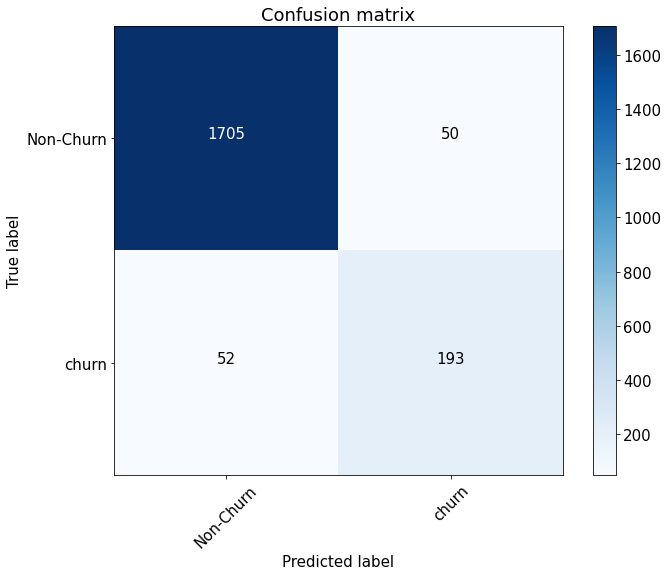

In [483]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [484]:
roc = roc_auc_score(y_test, preds)

dftemp =  {
            "name":'median',
            "precision": precision[ix],
            "recall": recall[ix],
            "fscore":fscore[ix],
            "roc_auc_score":roc
        }
    
df2 = df2.append(dftemp, ignore_index=True)
print(df2.head(2))

     name  precision    recall    fscore  roc_auc_score
0    mean   0.628763  0.767347  0.691176       0.948744
1  median   0.795082  0.791837  0.793456       0.975882


In [485]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [486]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.211565,0.372615,0.155896,0.000000,0.091314,0.000000,0.129177,0.000000,0.154368,...,0.366699,0.345509,0.077028,0.073831,0.262702,0.0,0.170874,0.0,0.000000,0.046507
1,u108690,0.427425,0.068959,0.109566,0.014058,0.022238,0.037120,0.096110,0.019777,0.125419,...,0.050547,0.224888,0.071743,0.030942,0.135499,0.0,0.298468,0.0,0.017620,0.000000
2,u108339,0.404842,0.085474,0.098074,0.010718,0.071670,0.060743,0.120248,0.025195,0.091323,...,0.000000,0.277427,0.027287,0.040569,0.238169,0.0,0.046764,0.0,0.046173,0.024875


In [487]:
X = pd.merge(user_embeddings_max, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.211565,0.372615,0.155896,0.000000,0.091314,0.000000,0.129177,0.000000,0.154368,...,0.345509,0.077028,0.073831,0.262702,0.0,0.170874,0.0,0.000000,0.046507,0
1,u108690,0.427425,0.068959,0.109566,0.014058,0.022238,0.037120,0.096110,0.019777,0.125419,...,0.224888,0.071743,0.030942,0.135499,0.0,0.298468,0.0,0.017620,0.000000,1
2,u108339,0.404842,0.085474,0.098074,0.010718,0.071670,0.060743,0.120248,0.025195,0.091323,...,0.277427,0.027287,0.040569,0.238169,0.0,0.046764,0.0,0.046173,0.024875,1


In [488]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [489]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.05366184, 0.00108397, 0.74257622, 0.08515687, 0.00897623,
       0.07114657, 0.15054705, 0.00130433, 0.00391662, 0.14808133])

In [490]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.387383, F-Score=0.802, Precision=0.795, Recall=0.808


Confusion matrix, without normalization
[[1704   51]
 [  48  197]]


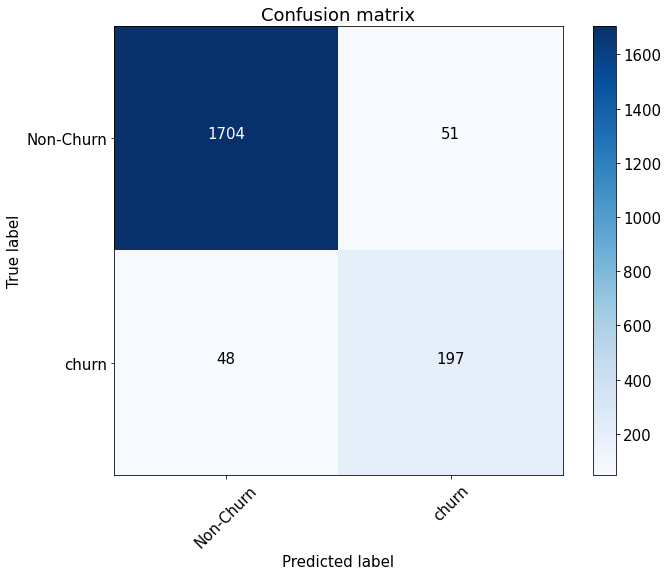

In [491]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [492]:
roc = roc_auc_score(y_test, preds)
dftemp2 =  {
            "name":'max',
            "precision": precision[ix],
            "recall": recall[ix],
            "fscore":fscore[ix],
            "roc_auc_score":roc
        }
    
df2 = df2.append(dftemp2, ignore_index=True)
print(df2)

     name  precision    recall    fscore  roc_auc_score
0    mean   0.628763  0.767347  0.691176       0.948744
1  median   0.795082  0.791837  0.793456       0.975882
2     max   0.795181  0.808163  0.801619       0.976664


Возможно метод max() по статья м более эффективен из-за того что пользователи в принципе прочитали не равное количество статей. И лучше их относить по статьям с максимальным совпадением по топикам.